In [1]:
from google.colab import drive
drive.mount("/content/gdrive/")

Mounted at /content/gdrive/


In [ ]:
!pwd

/content


In [2]:
import pdb
import pickle
import string

import time

import matplotlib.pyplot as plt
from nltk.corpus import stopwords, twitter_samples
from nltk.tokenize import TweetTokenizer

import pandas as pd
import numpy as np

from os import getcwd

In [76]:
def cosine_similarity(A, B):
    '''
    Input:
        A: a numpy array which corresponds to a word vector
        B: A numpy array which corresponds to a word vector
    Output:
        cos: numerical number representing the cosine similarity between A and B.
    '''

    dot = np.dot(A, B)
    # norma = np.sqrt(np.dot(A,A))
    # normb = np.sqrt(np.dot(B,B))
    norma = np.linalg.norm(A)
    normb = np.linalg.norm(B)
    if norma and normb !=0:
      cos = dot/(norma * normb)
    else:
      cos = 0

    return cos

In [4]:
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import TweetTokenizer
import re
import string

def process_tweet(tweet):
    """Process tweet function.
    Input:
        tweet: a string containing a tweet
    Output:
        tweets_clean: a list of words containing the processed tweet

    """
    stemmer = PorterStemmer()
    stopwords_english = stopwords.words('english')
    # remove stock market tickers like $GE
    tweet = re.sub(r'\$\w*', '', tweet)
    # remove old style retweet text "RT"
    tweet = re.sub(r'^RT[\s]+', '', tweet)
    # remove hyperlinks
    tweet = re.sub(r'https?:\/\/.*[\r\n]*', '', tweet)
    # remove hashtags
    # only removing the hash # sign from the word
    tweet = re.sub(r'#', '', tweet)
    # tokenize tweets
    tokenizer = TweetTokenizer(preserve_case=False, strip_handles=True,
                               reduce_len=True)
    tweet_tokens = tokenizer.tokenize(tweet)

    tweets_clean = []
    for word in tweet_tokens:
        if (word not in stopwords_english and  # remove stopwords
                word not in string.punctuation):  # remove punctuation
            # tweets_clean.append(word)
            stem_word = stemmer.stem(word)  # stemming word
            tweets_clean.append(stem_word)

    return tweets_clean

In [5]:
def get_dict(file_name):
    """
    This function returns the english to french dictionary given a file where the each column corresponds to a word.
    Check out the files this function takes in your workspace.
    """
    my_file = pd.read_csv(file_name, delimiter=' ')
    etof = {}  # the english to french dictionary to be returned
    for i in range(len(my_file)):
        # indexing into the rows.
        en = my_file.loc[i][0]
        fr = my_file.loc[i][1]
        etof[en] = fr

    return etof

**The word embeddings data for English and French words**

Write a program that translates English to French.

**The data**

To do the assignment on the Coursera workspace, we'll use the subset of word embeddings

In [6]:
path = '/content/gdrive/MyDrive/MHoseinAdibeig/NLP/'
en_embeddings_subset = pickle.load(open(path + "en_embeddings.p", "rb"))
fr_embeddings_subset = pickle.load(open(path + "fr_embeddings.p", "rb"))

**Load two dictionaries mapping the English to French words**



*   A training dictionary
*   and a testing dictionary.




In [7]:
en_fr_train = get_dict(path +'en-fr.train.txt')
print('The length of the English to French training dictionary is', len(en_fr_train))
en_fr_test = get_dict(path + 'en-fr.test.txt')
print('The length of the English to French test dictionary is', len(en_fr_train))

The length of the English to French training dictionary is 5000
The length of the English to French test dictionary is 5000


In [ ]:
en_fr_train

{'the': 'la',
 'and': 'et',
 'was': 'était',
 'for': 'pour',
 'that': 'cela',
 'with': 'avec',
 'from': 'depuis',
 'this': 'ce',
 'utc': 'tuc',
 'his': 'son',
 'not': 'pas',
 'are': 'sont',
 'talk': 'parlez',
 'which': 'lequel',
 'also': 'egalement',
 'were': 'étaient',
 'but': 'mais',
 'have': 'ont',
 'one': 'one',
 'new': 'nouveautés',
 'first': 'premiers',
 'page': 'page',
 'you': 'you',
 'they': 'eux',
 'had': 'avais',
 'article': 'article',
 'who': 'who',
 'all': 'all',
 'their': 'leurs',
 'there': 'là',
 'made': 'fabriqué',
 'its': 'son',
 'people': 'personnes',
 'may': 'peut',
 'after': 'aprés',
 'other': 'autres',
 'should': 'devrais',
 'two': 'deux',
 'score': 'partition',
 'her': 'her',
 'can': 'peut',
 'would': 'ferait',
 'more': 'plus',
 'she': 'elle',
 'when': 'quand',
 'time': 'heure',
 'team': 'equipe',
 'american': 'américains',
 'such': 'telles',
 'discussion': 'débat',
 'links': 'liens',
 'only': 'seule',
 'some': 'quelques',
 'see': 'vois',
 'united': 'unies',
 'year

**Generate embedding and transform matrices**
* Translating English dictionary to French by using embeddings

In [8]:
def get_matrices(en_fr, french_vecs, english_vecs):
    """
    Input:
        en_fr: English to French dictionary
        french_vecs: French words to their corresponding word embeddings.
        english_vecs: English words to their corresponding word embeddings.
    Output:
        X: a matrix where the columns are the English embeddings.
        Y: a matrix where the columns correspong to the French embeddings.
        R: the projection matrix that minimizes the F norm ||X R -Y||^2.
    """

    # X_l and Y_l are lists of the english and french word embeddings
    X_1 = list()
    Y_1  =list()

    # Get the english words and store in a set
    english_set = english_vecs.keys()

    # Get the french words and store in a set()
    french_set = french_vecs.keys()

    # Store the french words that are part of the english-french dict
    french_words = set(en_fr.values())

    # Loop through all english, french word pair in the english french dictionary
    for en_word, fr_word in en_fr.items():

      # Check that the french word has an embedding and that the english word has an embedding
      if fr_word in french_set and en_word in english_set:

        # Get the english embeddings:
        en_vec = english_vecs[en_word]

        # Get the french embeddings
        fr_vec = french_vecs[fr_word]

        # Add the english embedding to the list
        X_1.append(en_vec)

        # Add the french embedding to the list
        Y_1.append(fr_vec)

    # Stack the vectors of X_l into a matrix X
    X = np.vstack(X_1)
    # Stack the vectors of Y_l into a matrix Y
    Y = np.vstack(Y_1)

    return X, Y

In [9]:
# getting the training set:
X_train, Y_train = get_matrices(
    en_fr_train, fr_embeddings_subset, en_embeddings_subset)

**Translation as linear transformation of embeddings**


In [10]:
def compute_loss(X, Y, R):
    '''
    Inputs:
        X: a matrix of dimension (m,n) where the columns are the English embeddings.
        Y: a matrix of dimension (m,n) where the columns correspong to the French embeddings.
        R: a matrix of dimension (n,n) - transformation matrix from English to French vector space embeddings.
    Outputs:
        L: a matrix of dimension (m,n) - the value of the loss function for given X, Y and R.
    '''
    # m is the number of rows in X
    m = X.shape[0]

    # Dif is XR - Y
    diff = np.dot(X, R) - Y

    # Diff_squared is the element-wise square of the difference
    diff_squared = np.square(diff)

    # sum_diff_squared is the sum of the squared elements
    sum_diff_squared = np.sum(diff_squared)

    # Loss i the sum_diff_squared divided by the number of examples (m)
    loss = sum_diff_squared / m

    return loss



**Step 2: Computing the gradient of loss in respect to transform matrix R**

In [11]:
def compute_gradient(X, Y, R):
    '''
    Inputs:
        X: a matrix of dimension (m,n) where the columns are the English embeddings.
        Y: a matrix of dimension (m,n) where the columns correspong to the French embeddings.
        R: a matrix of dimension (n,n) - transformation matrix from English to French vector space embeddings.
    Outputs:
        g: a matrix of dimension (n,n) - gradient of the loss function L for given X, Y and R.
    '''
    m = X.shape[0]

    # Gradient is X.T(XR - Y) * 2/m
    gradient = np.dot(X.transpose(),np.dot(X,R)-Y)*(2/m)

    return gradient

**Step 3: Finding the optimal R with gradient descent algorithm**


In [12]:
def align_embeddings(X, Y, train_steps = 100, learning_rate = 0.0003):
    '''
    Inputs:
        X: a matrix of dimension (m,n) where the columns are the English embeddings.
        Y: a matrix of dimension (m,n) where the columns correspong to the French embeddings.
        train_steps: positive int - describes how many steps will gradient descent algorithm do.
        learning_rate: positive float - describes how big steps will  gradient descent algorithm do.
    Outputs:
        R: a matrix of dimension (n,n) - the projection matrix that minimizes the F norm ||X R -Y||^2
    '''
    np.random.seed(129)

    # R is a square matrix with length equal to the number of dimensions in th  word embedding
    R = np.random.rand(X.shape[1], X.shape[1])

    for i in range(train_steps):
      if i % 25 == 0:
        print(f"loss at iteratuion {i} is: {compute_loss(X, Y, R): .4f}")

        gradient = compute_gradient(X, Y, R)

        # Update R by subtracting the learning rate times gradient
        R -= learning_rate * gradient

    return R

In [13]:
# Testing your implementation.
np.random.seed(129)
m = 10
n = 5
X = np.random.rand(m, n)
Y = np.random.rand(m, n) * .1
R = align_embeddings(X, Y)

loss at iteratuion 0 is:  3.7242
loss at iteratuion 25 is:  3.7203
loss at iteratuion 50 is:  3.7164
loss at iteratuion 75 is:  3.7125


**Calculate transformation matrix R**

Using those the training set, find the transformation matrix R by calling the function align_embeddings()

In [14]:
R_train = align_embeddings(X_train, Y_train, train_steps=6000, learning_rate=0.8)

loss at iteratuion 0 is:  963.0146
loss at iteratuion 25 is:  687.7241
loss at iteratuion 50 is:  598.8697
loss at iteratuion 75 is:  529.9030
loss at iteratuion 100 is:  473.7823
loss at iteratuion 125 is:  426.9761
loss at iteratuion 150 is:  387.2205
loss at iteratuion 175 is:  352.9541
loss at iteratuion 200 is:  323.0640
loss at iteratuion 225 is:  296.7358
loss at iteratuion 250 is:  273.3597
loss at iteratuion 275 is:  252.4683
loss at iteratuion 300 is:  233.6956
loss at iteratuion 325 is:  216.7495
loss at iteratuion 350 is:  201.3927
loss at iteratuion 375 is:  187.4294
loss at iteratuion 400 is:  174.6958
loss at iteratuion 425 is:  163.0534
loss at iteratuion 450 is:  152.3840
loss at iteratuion 475 is:  142.5856
loss at iteratuion 500 is:  133.5698
loss at iteratuion 525 is:  125.2593
loss at iteratuion 550 is:  117.5865
loss at iteratuion 575 is:  110.4915
loss at iteratuion 600 is:  103.9214
loss at iteratuion 625 is:  97.8292
loss at iteratuion 650 is:  92.1728
loss at 

**Testing the translation**

k-Nearest neighbors algorithm:
  * k-NN is a method which takes a vector as input and finds the other vectors in the dataset that are closest to it.
  * The 'k' is the number of "nearest neighbors" to find (e.g. k=2 finds the closest two neighbors).



In [15]:
def nearest_neighbor(v, candidates, k = 1):
    """
    Input:
      - v, the vector you are going find the nearest neighbor for
      - candidates: a set of vectors where we will find the neighbors
      - k: top k nearest neighbors to find
    Output:
      - k_idx: the indices of the top k closest vectors in sorted form
    """

    similarity = []

    # For each candidate vector...
    for row in candidates:
      # Get the cosine similarity
      cos_similarity = cosine_similarity(v, row)

      # Append the similarity to the list
      similarity.append(cos_similarity)

    # Sort the similarity list and get the indices of the sorted list
    sorted_list = np.argsort(similarity)

    # Get the similarity of the k most similar candidate vectors
    k_idx = sorted_list[-k:]

    return k_idx

In [16]:
# Test your implementation:
v = np.array([1, 0, 1])
candidates = np.array([[1, 0, 5], [-2, 5, 3], [2, 0, 1], [6, -9, 5], [9, 9, 9]])
print(nearest_neighbor(v, candidates, 3))
print(candidates[nearest_neighbor(v, candidates, 3)])

[4 0 2]
[[9 9 9]
 [1 0 5]
 [2 0 1]]


In [17]:
def test_vocabulary(X, Y, R):
    '''
    Input:
        X: a matrix where the columns are the English embeddings.
        Y: a matrix where the columns correspong to the French embeddings.
        R: the transform matrix which translates word embeddings from
        English to French word vector space.
    Output:
        accuracy: for the English to French capitals
    '''
    # Prediction is X times R
    pred = np.dot(X, R)

    # Initialize the number correct to zero
    num_correct = 0

    # Loop through each row in pred
    for i in range(len(pred)):
      # Get the index of the nearest neighbor of pred at row 'i'
      pred_idx = nearest_neighbor(pred[i], Y)

      # If the index of the nearest neighbor equals the row of i...
      if pred_idx == i:
        num_correct += 1

    # Accuracy is the number correct divided by the number of rows in pred
    accuracy = num_correct / len(pred)

    return accuracy


In [18]:
X_val, Y_val = get_matrices(en_fr_test, fr_embeddings_subset, en_embeddings_subset)

In [19]:
acc = test_vocabulary(X_val, Y_val, R_train)  # this might take a minute or two
print(f"accuracy on test set is {acc:.3f}")

accuracy on test set is 0.522


**LSH and document search**

In this part of the assignment, you will implement a more efficient version of k-nearest neighbors using locality sensitive hashing. You will then apply this to document search.

* Process the tweets and represent each tweet as a vector (represent a document with a vector embedding).

* Use locality sensitive hashing and k nearest neighbors to find tweets that are similar to a given tweet.

In [29]:
 import nltk
 nltk.download('twitter_samples')
 nltk.download('stopwords')

[nltk_data] Downloading package twitter_samples to /root/nltk_data...
[nltk_data]   Package twitter_samples is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [27]:
import nltk
# get the positive and negative tweets
all_positive_tweets = twitter_samples.strings('positive_tweets.json')
all_negative_tweets = twitter_samples.strings('negative_tweets.json')
all_tweets = all_positive_tweets + all_negative_tweets

**Getting the document embeddings**

Bag-of-words (BOW) document models:

Text documents are sequences of words.

* The ordering of words makes a difference. For example, sentences "Apple pie is better than pepperoni pizza." and "Pepperoni pizza is better than apple pie" have opposite meanings due to the word ordering.

* However, for some applications, ignoring the order of words can allow us to train an efficient and still effective model.

* This approach is called Bag-of-words document model.

**Document embeddings**

* Document embedding is created by summing up the embeddings of all words in the document.
* If we don't know the embedding of some word, we can ignore that word.

* The function get_document_embedding() encodes entire document as a "document" embedding.

* It takes in a docoument (as a string) and a dictionary, en_embeddings

* It processes the document, and looks up the corresponding embedding of each word.

* It then sums them up and returns the sum of all word vectors of that processed tweet.

In [33]:
def get_document_embedding(tweet, en_embeddings):
    '''
    Input:
        - tweet: a string
        - en_embeddings: a dictionary of word embeddings
    Output:
        - doc_embedding: sum of all word embeddings in the tweet
    '''
    doc_embedding  =np.zeros(300)

    # Process the document into a list of words(process the tweet)
    processed_doc = process_tweet(tweet)
    for word in processed_doc:
      # Add the word embedding to the running total for the document embedding
      doc_embedding += en_embeddings.get(word, 0)

    return doc_embedding

In [34]:
# testing your function
custom_tweet = "RT @Twitter @chapagain Hello There! Have a great day. :) #good #morning http://chapagain.com.np"
tweet_embedding = get_document_embedding(custom_tweet, en_embeddings_subset)
tweet_embedding[-5:]

array([-0.00268555, -0.15378189, -0.55761719, -0.07216644, -0.32263184])

**Store all document vectors into a dictionary**

Now, let's store all the tweet embeddings into a dictionary

In [37]:
def get_document_vecs(all_docs, en_embeddings):
    '''
    Input:
        - all_docs: list of strings - all tweets in our dataset.
        - en_embeddings: dictionary with words as the keys and their embeddings as the values.
    Output:
        - document_vec_matrix: matrix of tweet embeddings.
        - ind2Doc_dict: dictionary with indices of tweets in vecs as keys and their embeddings as the values.
    '''
    # The dictionary's key is an index that identifies a specific tweet
    # The value is the document embedding for that document
    ind2Doc_dict = {}

    # This is a list that will store the document vectors
    document_vec_1 = []

    for i, doc in enumerate(all_docs):

      # Getthe document embedding of the tweet
       doc_embedding = get_document_embedding(doc, en_embeddings)

       # Save the document embedding into the ind2Tweet
       ind2Doc_dict[i] = doc_embedding

       # Append the docuent embedding to the list of document vectors
       document_vec_1.append(doc_embedding)

    # Convert the list of document vectors into a 2D array (each row is a document vector)
    document_vec_matrix = np.vstack(document_vec_1)

    return document_vec_matrix, ind2Doc_dict

In [38]:
document_vecs, ind2Tweet = get_document_vecs(all_tweets, en_embeddings_subset)

In [64]:
print(f"length of dictionary {len(ind2Tweet)}")
print(f"shape of document_vecs {document_vecs.shape}")

length of dictionary 10000
shape of document_vecs (10000, 300)


**Looking up the tweets**

Now you have a vector of dimension (m,d) where m is the number of tweets (10,000) and d is the dimension of the embeddings (300). Now you will input a tweet, and use cosine similarity to see which tweet in our corpus is similar to your tweet.


In [65]:
my_tweet = 'i am sad'
process_tweet(my_tweet)
tweet_embedding = get_document_embedding(my_tweet, en_embeddings_subset)

In [78]:
# this gives you a similar tweet as your input.
# this implementation is vectorized...
idx = np.argmax([cosine_similarity(doc, tweet_embedding) for doc in document_vecs])
# idx = np.argmax(cosine_similarity(document_vecs, tweet_embedding))
print(all_tweets[idx])

@hanbined sad pray for me :(((


**Finding the most similar tweets with LSH**

You will now implement locality sensitive hashing (LSH) to identify the most similar tweet.

* Instead of looking at all 10,000 vectors, you can just search a subset to find its nearest neighbors.

In [79]:
N_VECS = len(all_tweets)       # This many vectors.
N_DIMS = len(ind2Tweet[1])     # Vector dimensionality.
print(f"Number of vectors is {N_VECS} and each has {N_DIMS} dimensions.")

Number of vectors is 10000 and each has 300 dimensions.


**Choosing the number of planes**

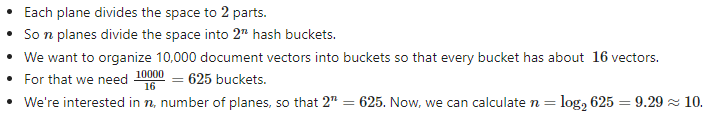


In [ ]:
# The number of planes. We use log2(625) to have ~16 vectors/bucket.
N_PLANES = 10
# Number of times to repeat the hashing to improve the search.
N_UNIVERSES = 25

**Getting the hash number for a vector**

For each vector, we need to get a unique number associated to that vector in order to assign it to a "hash bucket".

**Hyperlanes in vector spaces**

![image.png]()

**Using Hyperplanes to split the vector space**

We can use a hyperplane to split the vector space into
 parts.

* All vectors whose dot product with a plane's normal vector is positive are on one side of the plane.

* All vectors whose dot product with the plane's normal vector is negative are on the other side of the plane.

**Encoding hash buckets**

* For a vector, we can take its dot product with all the planes, then encode this information to assign the vector to a single hash bucket.

* When the vector is pointing to the opposite side of the hyperplane than normal, encode it by 0.

* Otherwise, if the vector is on the same side as the normal vector, encode it by 1.

* If you calculate the dot product with each plane in the same order for every vector, you've encoded each vector's unique hash ID as a binary number, like [0, 1, 1, ... 0].

**Implementing hash buckets**

In [81]:
np.random.seed(0)
planes_l = [np.random.normal(size=(N_DIMS, N_PLANES))
            for _ in range(N_UNIVERSES)]

In [85]:
len(planes_l)
planes_l[0].shape

(300, 10)

In [96]:
v = np.random.rand(1, 300)
w = np.dot(v, planes_l[0])
w.shape
w = list(w)

In [97]:
h = [True for dot in w if dot > 0 else False]
h

SyntaxError: invalid syntax (<ipython-input-97-bf38201ae0af>, line 1)

In [90]:
help(np.random.rand)

Help on built-in function rand:

rand(...) method of numpy.random.mtrand.RandomState instance
    rand(d0, d1, ..., dn)
    
    Random values in a given shape.
    
    .. note::
        This is a convenience function for users porting code from Matlab,
        and wraps `random_sample`. That function takes a
        tuple to specify the size of the output, which is consistent with
        other NumPy functions like `numpy.zeros` and `numpy.ones`.
    
    Create an array of the given shape and populate it with
    random samples from a uniform distribution
    over ``[0, 1)``.
    
    Parameters
    ----------
    d0, d1, ..., dn : int, optional
        The dimensions of the returned array, must be non-negative.
        If no argument is given a single Python float is returned.
    
    Returns
    -------
    out : ndarray, shape ``(d0, d1, ..., dn)``
        Random values.
    
    See Also
    --------
    random
    
    Examples
    --------
    >>> np.random.rand(3,2)
    arra

In [102]:
def hash_value_of_vector(v, planes):
    """Create a hash for a vector; hash_id says which random hash to use.
    Input:
        - v:  vector of tweet. It's dimension is (1, N_DIMS)
        - planes: matrix of dimension (N_DIMS, N_PLANES) - the set of planes that divide up the region
    Output:
        - res: a number which is used as a hash for your vector

    """
    # For the set of planes,
    # calculate the dot product between the vector and the matrix containing the planes
    # remember that planes has shape (300, 10)
    # The dot product will have the shape (1, 10)
    dot_product = np.dot(v, planes)

    # Get the sign of the dot product (1, 10) shaped vector
    sign_of_dot_vector = np.sign(dot_product)

    # Set h to be false if the sign is negative,
    # and true if the sign is positive (1, 10) shaped vector
    h = sign_of_dot_vector >= 0

    # Remove extra un-used dimensions
    h = h.squeeze()

    # Initialize the hash value to 0
    hash_value = 0

    n_planes = planes.shape[1]
    for i in range(n_planes):
      # Increment the hash value by 2^i * h_i
      hash_value += np.power(2, i) * h[i]

    # Cast hash_value as an integer
    hash_value = int(hash_value)

    return hash_value

In [103]:
np.random.seed(0)
idx = 0
planes = planes_l[idx]  # get one 'universe' of planes to test the function
vec = np.random.rand(1, 300)
print(f" The hash value for this vector,",
      f"and the set of planes at index {idx},",
      f"is {hash_value_of_vector(vec, planes)}")

 The hash value for this vector, and the set of planes at index 0, is 768


**Creating a hash table**

Given that you have a unique number for each vector (or tweet), You now want to create a hash table. You need a hash table, so that given a hash_id, you can quickly look up the corresponding vectors. This allows you to reduce your search by a significant amount of time.

We have given you the make_hash_table function, which maps the tweet vectors to a bucket and stores the vector there. It returns the hash_table and the id_table. The id_table allows you know which vector in a certain bucket corresponds to what tweet.

In [ ]:
def make_hash_table(vecs, planes):
    """
    Input:
        - vecs: list of vectors to be hashed.
        - planes: the matrix of planes in a single "universe", with shape (embedding dimensions, number of planes).
    Output:
        - hash_table: dictionary - keys are hashes, values are lists of vectors (hash buckets)
        - id_table: dictionary - keys are hashes, values are list of vectors id's
                            (it's used to know which tweet corresponds to the hashed vector)
    """
    # Number of planes is the number of columns in the planes matrix
    num_of_planes = planes_l[0].shape[1]

    # Number of buckets is 2^(number of planes)
    num_buckets = np.power(2, num_of_planes)

    # Create the hash table as dictionary.
    # Keys are integers (0, 1, 2, ..., number of buckets)
    # Values are empty list
    hash_table = {i:[] for i in range(num_buckets)}

    # Create the id table as a dictionary.
    # Keys are integer (0, 1, 2, ... number of buckets)
    # Values are empty list
    id_table =  {i:[] for i in range(num_buckets)}

    # For each vector in 'vecs'
    for i, v in enumerate(vecs):
      # Calculate the hash value for the vector
      h =  hash_value_of_vector(v)

      # Store the vector into hash_table at key h
      # by appending the vector v to the list at key h


In [59]:
nparray1 = np.array([0, 1, 2, 3]) # Define an array
nparray2 = np.array([4, 5, 6, 7]) # Define an array

flavor1 = np.dot(nparray1, nparray2) # Recommended way
print(flavor1)

38


In [60]:
nparray1.shape

(4,)

In [ ]:
A = np.array([[1, 2, 3],
             [-1, 0, 1]])
np.square(A)

array([[1, 4, 9],
       [1, 0, 1]])

In [ ]:
for en_word, fr_word in en_fr_train.items():
  print(en_word, fr_word)

the la
and et
was était
for pour
that cela
with avec
from depuis
this ce
utc tuc
his son
not pas
are sont
talk parlez
which lequel
also egalement
were étaient
but mais
have ont
one one
new nouveautés
first premiers
page page
you you
they eux
had avais
article article
who who
all all
their leurs
there là
made fabriqué
its son
people personnes
may peut
after aprés
other autres
should devrais
two deux
score partition
her her
can peut
would ferait
more plus
she elle
when quand
time heure
team equipe
american américains
such telles
discussion débat
links liens
only seule
some quelques
see vois
united unies
years ans
school école
world mondiale
university universitaire
during lors
out out
state état
states états
national nationales
wikipedia wikipedia
year année
most most
city villes
used utilisée
then puis
county comté
external externes
where où
will sera
what quelle
delete effacer
these ces
january janvier
march mars
august août
july juillet
being être
film film
him lui
many plusieurs
sout

In [ ]:
en_fr_train.items()

AttributeError: 'dict_items' object has no attribute 'next'